In [1]:
import pymongo
from pymongo import MongoClient
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from sklearn import preprocessing
from nbi1 import *
import warnings

warnings.filterwarnings('ignore')

## Import data

In [34]:
# Importing with outliers
df = pd.read_csv("02-20-19-thesis-dataset", index_col = 0)

# Importing without outliers
df_wo = pd.read_csv("02-20-19-thesis-dataset-without-outliers", index_col = 0)

## Analysis

### Effect by Regions

#### Categorizing bridges according to their regions

In [3]:
# Northeast
N = ['09','23','25','33','44','50','34','36','42']  

# Midwest
M = ['17','18','21','39','55','19','20','27','29','31','38','46']

# South
S = ['10','12','13','24','37','45','51','11','54','01','21','28','47','05','22','40','48']

# West
W = ['04','08','16','32','30','35','49','56','01','06','15','41','53','72']

# Creating separate dataframes for regions
west_df = df_wo[df_wo["State Code"].isin(W)]
south_df = df_wo[df_wo["State Code"].isin(S)]
midwest_df = df_wo[df_wo["State Code"].isin(M)]
northeast_df = df_wo[df_wo["State Code"].isin(N)]

#### Sampling 

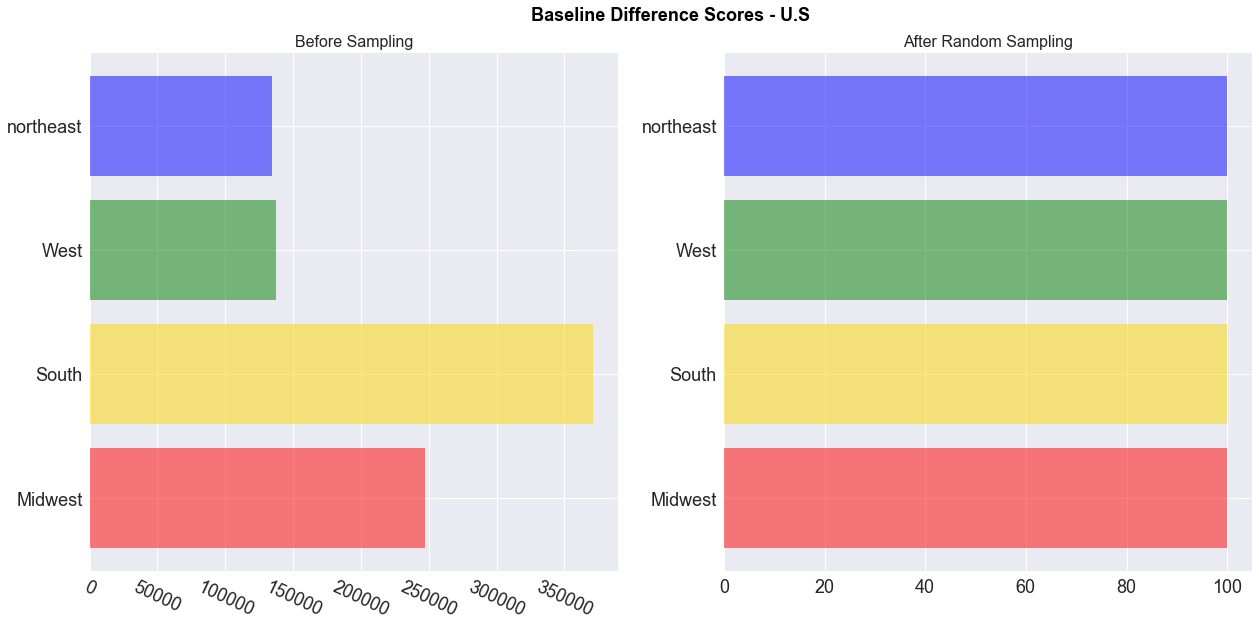

In [4]:
# Length of the dataframe of regions
len_west = len(west_df)
len_midwest = len(midwest_df)
len_south = len(south_df)
len_northeast = len(northeast_df)

# Random Sample of 100
ns = 100

w_df = west_df.sample(n=ns)
m_df = midwest_df.sample(n=ns)
s_df = south_df.sample(n=ns)
n_df = northeast_df.sample(n=ns)

# Baseline Difference Scores of the Regions.
west_base = w_df['Baseline Difference Score'].tolist()
midwest_base = m_df['Baseline Difference Score'].tolist() 
south_base = s_df['Baseline Difference Score'].tolist()
north_base = n_df['Baseline Difference Score'].tolist()


# Plotting 
plt.figure(figsize=(17,8))
plt.subplots_adjust(bottom=0, left=0.025, top = 0.9, right=0.975)
plt.suptitle("Baseline Difference Scores - U.S", fontsize = 18, fontweight = 'bold')
sns.set(font_scale=2)

#Subplot 1
plt.subplot(1,2,1)
plt.subplot(1,2,1).set_title("Before Sampling", fontsize = 16)
regions = ["West", "Midwest", "South", "northeast"]
no_of_records = [len_west, len_midwest, len_south, len_northeast]
plt.barh(regions, no_of_records, align = 'center', alpha = 0.5, color = ['Green','Red','Gold','Blue'])
plt.xticks(size = 18, rotation = -25)
plt.yticks(size =18)



# Subplot 2
plt.subplot(1,2,2)
plt.subplot(1,2,2).set_title("After Random Sampling", fontsize = 16)
no_of_records = [len(w_df), len(m_df), len(s_df), len(n_df)]
plt.barh(regions, no_of_records, align = 'center', alpha = 0.5, color = ['Green','Red','Gold','Blue'])
plt.xticks(size = 18)
plt.yticks(size = 18)



plt.show()


#### Baseline Difference Score Distribution of the Regions

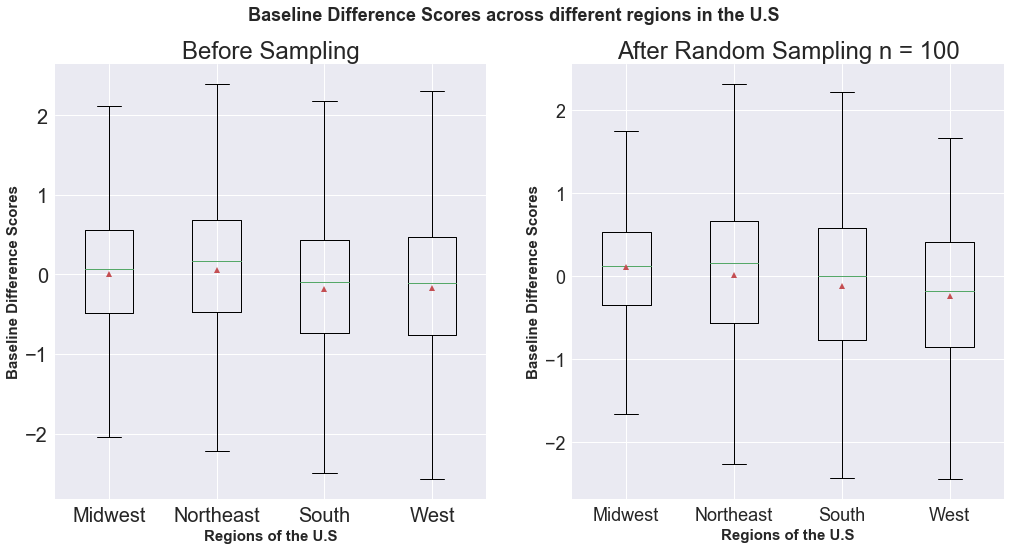

In [33]:
plt.figure(figsize=(17,8))

data = [west_df['Baseline Difference Score'].tolist(), midwest_df['Baseline Difference Score'].tolist(), south_df['Baseline Difference Score'].tolist(), northeast_df['Baseline Difference Score'].tolist()]
labels = ["Midwest","Northeast","South","West"]
plt.suptitle("Baseline Difference Scores across different regions in the U.S", fontsize = 18, fontweight = 'bold') 
plt.title('Outliers are ignored')

# Subplot 1
plt.subplot(1,2,1)
plt.subplot(1,2,1).set_title("Before Sampling")
plt.boxplot(data, labels = labels, showfliers=True, showmeans=True)
plt.ylabel('Baseline Difference Scores', fontweight = 'bold', size = 15)
plt.xlabel("Regions of the U.S", fontweight = 'bold', size = 15)

# Subplot 2
plt.subplot(1,2,2)
plt.subplot(1,2,2).set_title("After Random Sampling n = 100")
data_sample = [west_base, midwest_base, south_base, north_base]
plt.boxplot(data_sample, labels = labels, showfliers=True, showmeans=True)
plt.ylabel('Baseline Difference Scores', fontweight = 'bold', size = 15)
plt.xlabel("Regions of the U.S", fontweight = 'bold', size = 15)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.show()


###  ANOVA

In [6]:
import scipy.stats as stats

#Function Hypothesis Testing.
def anova_result(stat, p_value):
    if p_value < 0.05:
        print("Stat:"+ str(stat))
        print("The p_value: "+str(p_value))
        print("Therefore we reject the Null Hypothesis - The average of the dependent variable is not the same for all groups")
    else:
        print("Stat:"+ str(stat))
        print("The p_value: "+str(p_value))
        print("Therefore we accept the Null Hypothesis - The average of the dependent variable is same for all groups")

#### One-way ANOVA

In [7]:
stat, p_value = stats.f_oneway(west_base, 
                               midwest_base,
                               south_base, 
                               north_base) 
## Results
anova_result(stat, p_value)

Stat:2.9006692551489954
The p_value: 0.03481589514802555
Therefore we reject the Null Hypothesis - The average of the dependent variable is not the same for all groups


### Post-hoc Testing

The test result suggests the groups don't have the same sample means in this case, since the p-value is significant at a 99% confidence level.
we know that the scores in the regions differ, but we do not know which region caused the test to throw a positive result. To check which region from the regions differ after getting a positive anova result. we can perform a follow up 'post-hoc test'
One post-hoc test to perform is a separate t-test for each pair of regions. 

#### Separate t-test of each pair of regions

In [8]:
# Dataframe of each region as a column
region_df = pd.DataFrame({'West':west_base,'Midwest':midwest_base,'South':south_base, 'Northeast': north_base})

# Dataframe of column of region and column of score
baselines = west_base+midwest_base+south_base+north_base
regions = ['West']*(len(west_base))+['Midwest']*(len(west_base))+['South']*(len(west_base))+['Northeast']*(len(west_base))
phoc_region_df = pd.DataFrame({'Region':regions, 'Baseline Difference Score':baselines})

# Function: returns a x into 2 dimension of list of pairs
def getPairs(columns_list):
    pairs = []
    for col1 in range(3):
        for col2  in range(col1+1,4):
            pairs.append((columns_list[col1], columns_list[col2]))
    return pairs

columns_list = ['West','Midwest','South','Northeast']
pairs = getPairs(columns_list)

# Function: performs separate t-test on pairs of groups
def ttest(df,pairs):
    Col1 = []
    Col2 = []
    Stats = []
    pvalues = []
    Results = []
    for column1, column2 in pairs:
        stat, p = stats.ttest_ind(df[column1], df[column2])
        Col1.append(column1)
        Col2.append(column2)
        Stats.append(stat)
        pvalues.append(p)
        if p < 0.05:
            result = 'True'
        else:
            result = 'False'
        Results.append(result)
        
    df = pd.DataFrame({'Group 1':Col1, 'Group 2':Col2, 'Statistic':Stats, 'p-value':pvalues, 'Reject':Results})
    return df

# Results of separate t-test of pairs of groups
results_df =  ttest(region_df,pairs)

# Result
results_df

,Group 1,Group 2,Reject,Statistic,p-value
0,West,Midwest,False,0.806461,0.420945
1,West,South,False,1.872863,0.062561
2,West,Northeast,True,2.932612,0.003757
3,Midwest,South,False,0.974839,0.330830
4,Midwest,Northeast,False,1.918267,0.056516
5,South,Northeast,False,0.921484,0.357919


Bridges in south are likely different from Midwest and west. condition rating are likely different in midwest and northeast
The p-values for each pairwise t-test suggest mean of white voters is likely different from the other groups, since the p-values for each t-test involving the white group is below 0.05. Using unadjusted pairwise t-tests can overestimate significance, however, because the more comparisons you make, the more likely you are to come across an unlikely result due to chance. We can adjust for this multiple comparison problem by dividing the statistical significance level by the number of comparisons made. In this case, if we were looking for a significance level of 5%, we'd be looking for p-values of 0.05/10 = 0.005 or less. This simple adjustment for multiple comparisons is known as the Bonferroni correction.
The Bonferroni correction is a conservative approach to account for the multiple comparisons problem that may end up rejecting results that are actually significant. Another common post hoc-test is Tukey's test. You can carry out Tukey's test using the pairwise_tukeyhsd() function in the statsmodels.stats.multicomp library:

group1,group2,meandiff,lower,upper,reject
Midwest,Northeast,-0.2534,-0.58,0.0732,False
Midwest,South,-0.1303,-0.4569,0.1964,False
Midwest,West,0.0961,-0.2305,0.4227,False
Northeast,South,0.1231,-0.2035,0.4498,False
Northeast,West,0.3495,0.0229,0.6761,True
South,West,0.2264,-0.1003,0.553,False


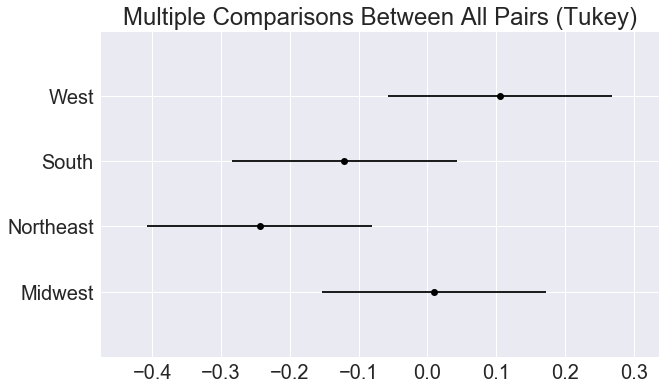

In [9]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=phoc_region_df['Baseline Difference Score'].tolist(),# Scores
                          groups=phoc_region_df['Region'].tolist(),   # Groups in the region
                          alpha=0.05)   
tukey.plot_simultaneous()    
tukey.summary()

The output of the Tukey test shows the average difference, a confidence interval as well as whether you should reject the null hypothesis for each pair of groups at the given significance level. In this case, the test suggests we reject the null hypothesis for 3 pairs, with each pair including the "white" category. This suggests the white group is likely different from the others. The 95% confidence interval plot reinforces the results visually: only 1 other group's confidence interval overlaps the white group's confidence interval.

### Effect of Average Daily Traffic 

#### Categorizing bridges according to their Average Daily Traffic

In [10]:
# Creating separate dataframes for (Average Daily Traffic) ADT Classes
light_df = df_wo[df_wo['ADT Category'] == 'Light']
heavy_df = df_wo[df_wo['ADT Category'] == 'Heavy']
moderate_df = df_wo[df_wo['ADT Category'] == 'Moderate']
very_light_df = df_wo[df_wo['ADT Category'] == 'Very Light']

#### Sampling

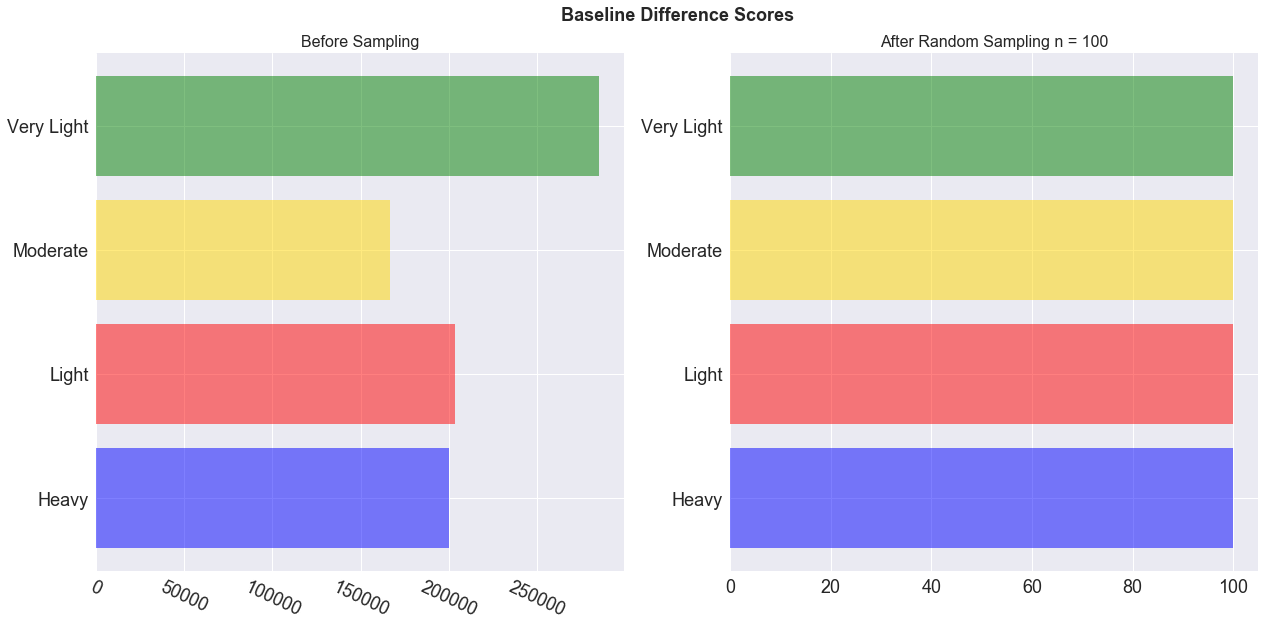

In [11]:
# Length of the dataframe of regions
len_light = len(light_df)
len_heavy = len(heavy_df)
len_moderate = len(moderate_df)
len_very_light = len(very_light_df)

# Random Sample of 100
ns = 100

samp_light_df = light_df.sample(n=ns)
samp_moderate_df = moderate_df.sample(n=ns)
samp_heavy_df = heavy_df.sample(n=ns)
samp_very_light_df = very_light_df.sample(n=ns)

# Baseline Difference Scores of the Regions.
light_base = samp_light_df['Baseline Difference Score'].tolist()
moderate_base = samp_moderate_df['Baseline Difference Score'].tolist() 
heavy_base = samp_heavy_df['Baseline Difference Score'].tolist()
very_light_base = samp_very_light_df['Baseline Difference Score'].tolist()


# Plotting 
plt.figure(figsize=(17,8))
plt.subplots_adjust(bottom=0, left=0.025, top = 0.9, right=0.975)
plt.suptitle("Baseline Difference Scores", fontsize = 18, fontweight = 'bold')
sns.set(font_scale=2)

#Subplot 1
plt.subplot(1,2,1)
plt.subplot(1,2,1).set_title("Before Sampling", fontsize = 16)
labels = ["Very Light", "Light", "Moderate", "Heavy"]
no_of_records = [len_light, len_very_light, len_moderate, len_heavy]
plt.barh(labels, no_of_records, align = 'center', alpha = 0.5, color = ['Green','Red','Gold','Blue'])
plt.xticks(size = 18, rotation = -25)
plt.yticks(size =18)



# Subplot 2
plt.subplot(1,2,2)
plt.subplot(1,2,2).set_title("After Random Sampling n = 100", fontsize = 16)
no_of_records = [len(samp_very_light_df), len(samp_light_df), len(samp_moderate_df), len(samp_heavy_df)]
plt.barh(labels, no_of_records, align = 'center', alpha = 0.5, color = ['Green','Red','Gold','Blue'])
plt.xticks(size = 18)
plt.yticks(size =18)


plt.show()

#### Baseline Difference Score Distribution of the ADT categories

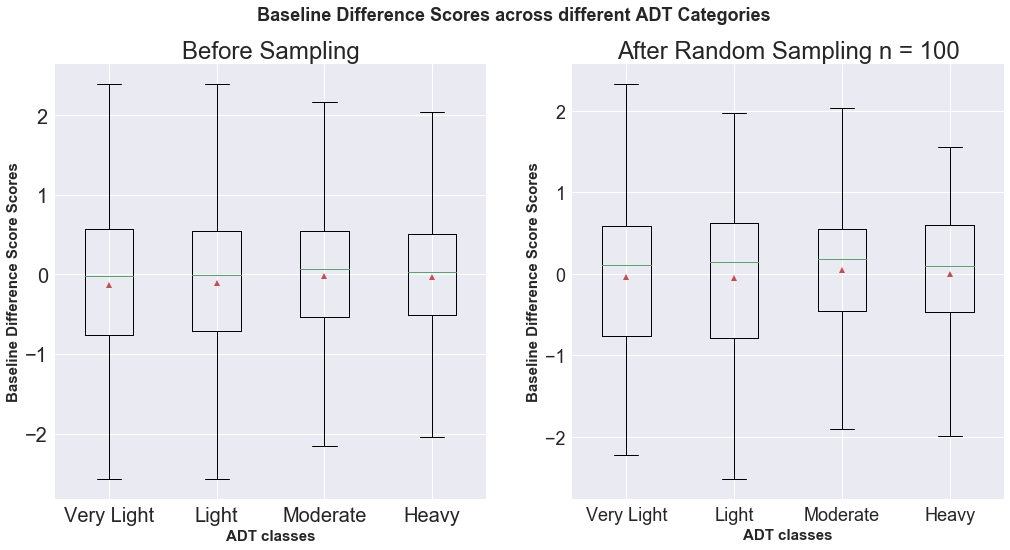

In [32]:
plt.figure(figsize=(17,8))

data = [very_light_df['Baseline Difference Score'].tolist(), light_df['Baseline Difference Score'].tolist(), moderate_df['Baseline Difference Score'].tolist(), heavy_df['Baseline Difference Score'].tolist()]
labels = ["Very Light","Light","Moderate","Heavy"]
plt.suptitle("Baseline Difference Scores across different ADT Categories", fontsize = 18, fontweight = 'bold') 
plt.title('Outliers are ignored')

# Subplot 1
plt.subplot(1,2,1)
plt.subplot(1,2,1).set_title("Before Sampling")
plt.boxplot(data, labels = labels, showfliers=True, showmeans=True)
plt.ylabel('Baseline Difference Score Scores', fontweight = 'bold', size = 15)
plt.xlabel("ADT classes", fontweight = 'bold', size = 15)

# Subplot 2
plt.subplot(1,2,2)
plt.subplot(1,2,2).set_title("After Random Sampling n = 100")
data_sample = [very_light_base, light_base, moderate_base, heavy_base]
plt.boxplot(data_sample, labels = labels, showfliers=True, showmeans=True)
plt.ylabel('Baseline Difference Score Scores', fontweight = 'bold', size = 15)
plt.xlabel("ADT classes", fontweight = 'bold', size = 15)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.show()


### ANOVA

#### One-way anova

In [13]:
stat, p_value = stats.f_oneway(very_light_base, 
                               light_base,
                               moderate_base, 
                               heavy_base) 
# Results
anova_result(stat, p_value)

Stat:0.2531703979157145
The p_value: 0.859070269255813
Therefore we accept the Null Hypothesis - The average of the dependent variable is same for all groups


#### Separate t-test 

In [14]:
# Dataframe of each region as a column
adt_df = pd.DataFrame({'Very Light':very_light_base,'Light':light_base,'Moderate':moderate_base, 'Heavy': heavy_base})

# Dataframe of column of region and column of score
baselines = very_light_base+light_base+moderate_base+heavy_base
adt = ['Very Light']*(len(very_light_base))+['Light']*(len(light_base))+['Moderate']*(len(moderate_base))+['Heavy']*(len(heavy_base))
phoc_adt_df = pd.DataFrame({'ADT Class':adt, 'Baseline Difference Score':baselines})

# Function: returns a x into 2 dimension of list of pairs
def getPairs(columns_list):
    pairs = []
    for col1 in range(3):
        for col2  in range(col1+1,4):
            pairs.append((columns_list[col1], columns_list[col2]))
    return pairs

columns_list = ['Very Light','Light','Moderate','Heavy']
pairs = getPairs(columns_list)

# Function: performs separate t-test on pairs of groups
def ttest(df,pairs):
    Col1 = []
    Col2 = []
    Stats = []
    pvalues = []
    Results = []
    for column1, column2 in pairs:
        stat, p = stats.ttest_ind(df[column1], df[column2])
        Col1.append(column1)
        Col2.append(column2)
        Stats.append(stat)
        pvalues.append(p)
        if p < 0.05:
            result = 'True'
        else:
            result = 'False'
        Results.append(result)
        
    df = pd.DataFrame({'Group 1':Col1, 'Group 2':Col2, 'Statistic':Stats, 'p-value':pvalues, 'Reject':Results})
    return df

# Results of separate t-test of pairs of groups
results_adt_df =  ttest(adt_df,pairs)

# Result
results_adt_df

,Group 1,Group 2,Reject,Statistic,p-value
0,Very Light,Light,False,0.135739,0.892165
1,Very Light,Moderate,False,-0.657612,0.511551
2,Very Light,Heavy,False,-0.315280,0.752881
3,Light,Moderate,False,-0.806722,0.420795
4,Light,Heavy,False,-0.461834,0.644707
5,Moderate,Heavy,False,0.369325,0.712280


#### Tukey's Test

group1,group2,meandiff,lower,upper,reject
Heavy,Light,-0.0569,-0.3727,0.2589,False
Heavy,Moderate,0.0411,-0.2747,0.3569,False
Heavy,Very Light,-0.0389,-0.3547,0.2769,False
Light,Moderate,0.098,-0.2178,0.4138,False
Light,Very Light,0.018,-0.2978,0.3338,False
Moderate,Very Light,-0.08,-0.3958,0.2358,False


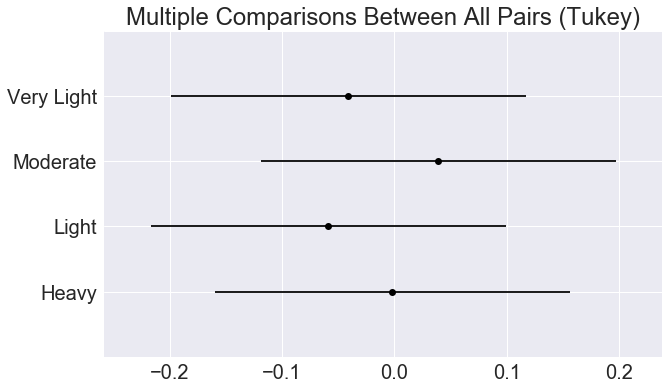

In [15]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=phoc_adt_df['Baseline Difference Score'].tolist(),# Scores
                          groups=phoc_adt_df['ADT Class'].tolist(),   # Groups in the region
                          alpha=0.05)   
tukey.plot_simultaneous()    
tukey.summary()

### Effect of Precipitation

#### Categorizing bridges according to their regions¶

#### Sampling 

In [31]:
df_wo['Precipitation Category']  =  pd.qcut(df_wo['Avg. Daily Precipitation'], 4, labels=["Very Light", "Light", "Moderate","Heavy"])

# Creating Dataframe for every category of Precipitation
light_precp_df = df_wo[df_wo['Precipitation Category'] == 'Light']
heavy_precp_df = df_wo[df_wo['Precipitation Category'] == 'Heavy']
moderate_precp_df = df_wo[df_wo['Precipitation Category'] == 'Moderate']
very_light_precp_df = df_wo[df_wo['Precipitation Category'] == 'Very Light']

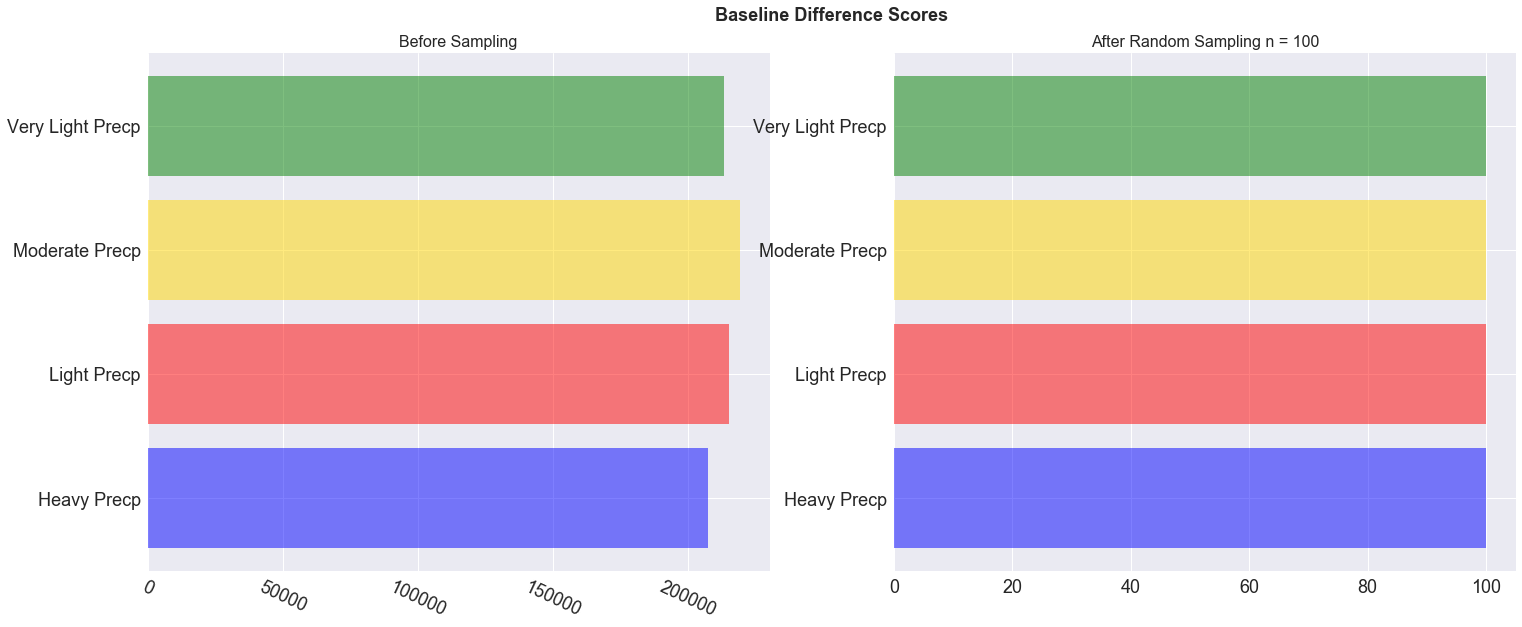

In [17]:
# Length of the dataframe of regions
len_light_precp = len(light_precp_df)
len_heavy_precp = len(heavy_precp_df)
len_moderate_precp = len(moderate_precp_df)
len_very_light_precp = len(very_light_precp_df)

# Random Sample of 100
ns = 100

samp_light_precp_df = light_precp_df.sample(n=ns)
samp_moderate_precp_df = moderate_precp_df.sample(n=ns)
samp_heavy_precp_df = heavy_precp_df.sample(n=ns)
samp_very_light_precp_df = very_light_precp_df.sample(n=ns)

# Baseline Difference Scores of the Regions.
light_precp_base = samp_light_precp_df['Baseline Difference Score'].tolist()
moderate_precp_base = samp_moderate_precp_df['Baseline Difference Score'].tolist() 
heavy_precp_base = samp_heavy_precp_df['Baseline Difference Score'].tolist()
very_light_precp_base = samp_very_light_precp_df['Baseline Difference Score'].tolist()


# Plotting 
plt.figure(figsize=(20,8))
plt.subplots_adjust(bottom=0, left=0.025, top = 0.9, right=0.975)
plt.suptitle("Baseline Difference Scores", fontsize = 18, fontweight = 'bold')
sns.set(font_scale=2)

#Subplot 1
plt.subplot(1,2,1)
plt.subplot(1,2,1).set_title("Before Sampling", fontsize = 16)
labels = ["Very Light Precp", "Light Precp", "Moderate Precp", "Heavy Precp"]
no_of_records = [len_light_precp, len_very_light_precp, len_moderate_precp, len_heavy_precp]
plt.barh(labels, no_of_records, align = 'center', alpha = 0.5, color = ['Green','Red','Gold','Blue'])
plt.xticks(size = 18, rotation = -25)
plt.yticks(size =18)



# Subplot 2
plt.subplot(1,2,2)
plt.subplot(1,2,2).set_title("After Random Sampling n = 100", fontsize = 16)
no_of_records = [len(samp_very_light_precp_df), len(samp_light_precp_df), len(samp_moderate_precp_df), len(samp_heavy_precp_df)]
plt.barh(labels, no_of_records, align = 'center', alpha = 0.5, color = ['Green','Red','Gold','Blue'])
plt.xticks(size = 18)
plt.yticks(size =18)

plt.show()

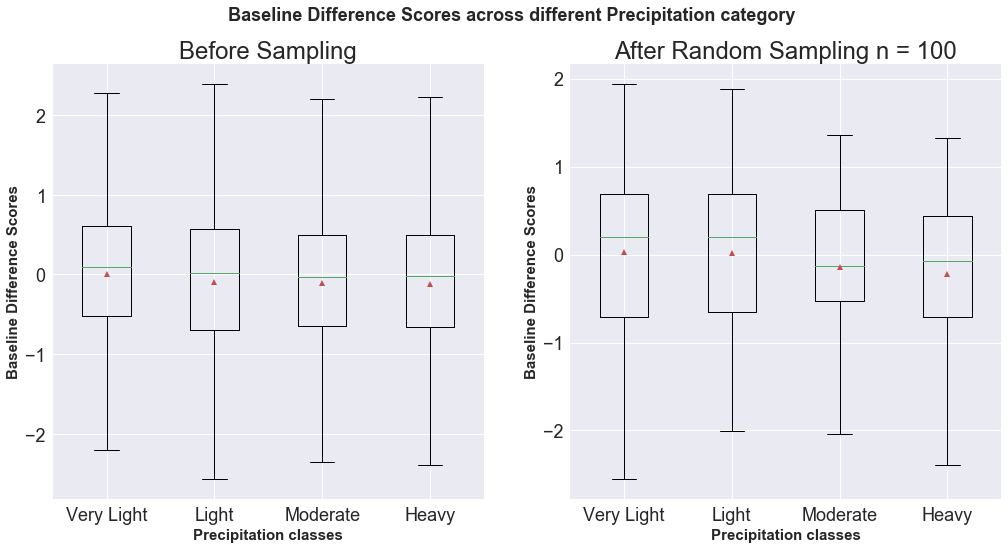

In [30]:
plt.figure(figsize=(17,8))

data = [very_light_precp_df['Baseline Difference Score'].tolist(), light_precp_df['Baseline Difference Score'].tolist(), moderate_precp_df['Baseline Difference Score'].tolist(), heavy_precp_df['Baseline Difference Score'].tolist()]
labels = ["Very Light","Light","Moderate","Heavy"]
plt.suptitle("Baseline Difference Scores across different Precipitation category", fontsize = 18, fontweight = 'bold') 
plt.title('Outliers are ignored')

# Subplot 1
plt.subplot(1,2,1)
plt.subplot(1,2,1).set_title("Before Sampling")
plt.boxplot(data, labels = labels, showfliers=True, showmeans=True)
plt.ylabel('Baseline Difference Scores', fontweight = 'bold', size = 15)
plt.xlabel("Precipitation classes", fontweight = 'bold', size = 15)
plt.xticks(size = 18)
plt.yticks(size = 18)


# Subplot 2
plt.subplot(1,2,2)
plt.subplot(1,2,2).set_title("After Random Sampling n = 100")
data_sample = [very_light_precp_base, light_precp_base, moderate_precp_base, heavy_precp_base]

plt.boxplot(data_sample, labels = labels, showfliers=True, showmeans=True)

plt.ylabel('Baseline Difference Scores', fontweight = 'bold', size = 15)
plt.xlabel("Precipitation classes", fontweight = 'bold', size = 15)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.show()

### ANOVA

#### One-way anova

In [19]:
stat, p_value = stats.f_oneway(very_light_precp_base, 
                               light_precp_base,
                               moderate_precp_base, 
                               heavy_precp_base) 
## Results
anova_result(stat, p_value)

Stat:1.9400106904719998
The p_value: 0.12255438223323808
Therefore we accept the Null Hypothesis - The average of the dependent variable is same for all groups


#### Separate t-test

In [20]:
# Dataframe of each region as a column
precp_df = pd.DataFrame({'Very Light':very_light_precp_base,'Light':light_precp_base,'Moderate':moderate_precp_base, 'Heavy': heavy_precp_base})

# Dataframe of column of region and column of score
baselines = very_light_precp_base+light_precp_base+moderate_precp_base+heavy_base
precp = ['Very Light']*(len(very_light_precp_base))+['Light']*(len(light_precp_base))+['Moderate']*(len(moderate_precp_base))+['Heavy']*(len(heavy_precp_base))
phoc_precp_df = pd.DataFrame({'ADT Class':precp, 'Baseline Difference Score':baselines})

# Function: returns a x into 2 dimension of list of pairs
def getPairs(columns_list):
    pairs = []
    for col1 in range(3):
        for col2  in range(col1+1,4):
            pairs.append((columns_list[col1], columns_list[col2]))
    return pairs

columns_list = ['Very Light','Light','Moderate','Heavy']
pairs = getPairs(columns_list)

# Function: performs separate t-test on pairs of groups
def ttest(df,pairs):
    Col1 = []
    Col2 = []
    Stats = []
    pvalues = []
    Results = []
    for column1, column2 in pairs:
        stat, p = stats.ttest_ind(df[column1], df[column2])
        Col1.append(column1)
        Col2.append(column2)
        Stats.append(stat)
        pvalues.append(p)
        if p < 0.05:
            result = 'True'
        else:
            result = 'False'
        Results.append(result)
        
    df = pd.DataFrame({'Group 1':Col1, 'Group 2':Col2, 'Statistic':Stats, 'p-value':pvalues, 'Reject':Results})
    return df

# Results of separate t-test of pairs of groups
results_precp_df =  ttest(precp_df,pairs)

# Result
results_precp_df

,Group 1,Group 2,Reject,Statistic,p-value
0,Very Light,Light,False,0.152916,0.878620
1,Very Light,Moderate,False,1.369033,0.172540
2,Very Light,Heavy,True,2.031920,0.043498
3,Light,Moderate,False,1.213740,0.226293
4,Light,Heavy,False,1.884182,0.061006
5,Moderate,Heavy,False,0.752088,0.452892


#### Tukey's Test

group1,group2,meandiff,lower,upper,reject
Heavy,Light,0.0148,-0.3051,0.3347,False
Heavy,Moderate,-0.1354,-0.4553,0.1845,False
Heavy,Very Light,0.0352,-0.2847,0.3551,False
Light,Moderate,-0.1502,-0.4701,0.1697,False
Light,Very Light,0.0204,-0.2994,0.3403,False
Moderate,Very Light,0.1706,-0.1493,0.4905,False


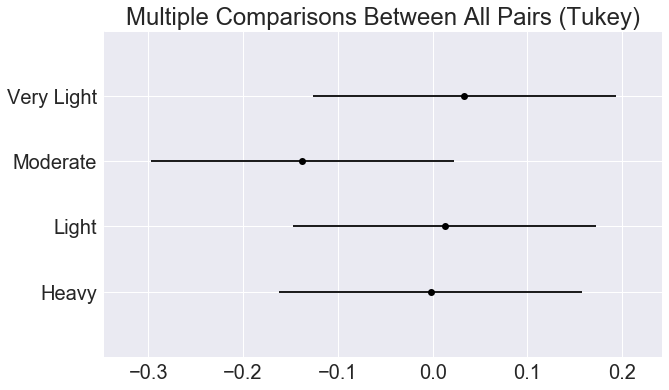

In [21]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=phoc_precp_df['Baseline Difference Score'].tolist(),# Scores
                          groups=phoc_precp_df['ADT Class'].tolist(),   # Groups in the region
                          alpha=0.05)   
tukey.plot_simultaneous()    
tukey.summary()

### Effect of Maintainers

#### Sampling

In [29]:
"""
Create Dataframe of only owners that belong to either of one:
 1. State Highway Agency,
 2. County Highway Agency,
 3. Town or Township Agency,
 4. City or Municipal Highway Agency 

""" 

df_owner = df_wo[df_wo['Owner'].isin([1,2,3,4])]

"""
The following is the code for the Agency:
    1 : State Highway Agency
    2 : County Highway Agency
    3 : Town or Township Highway Agency
    4 : City or Municipal Highway Agency

"""
# Dictionary of code and naming of the agencies
agency = {
         1 : "State Highway Agency",
         2 : "County Highway Agency",
         3 : "Town or Township Highway Agency",
         4 : "City or Municipal Highway Agency"
         }

# Column for owner name
df_owner['Owner Type'] = df_owner['Owner'].map(agency)

# Creating separate dataframe for the each owner
state_df = df_owner[df_owner['Owner Type'] == "State Highway Agency"]
county_df = df_owner[df_owner['Owner Type'] == "County Highway Agency"]
town_df = df_owner[df_owner['Owner Type'] == "Town or Township Highway Agency"]
city_df = df_owner[df_owner['Owner Type'] == "City or Municipal Highway Agency"]

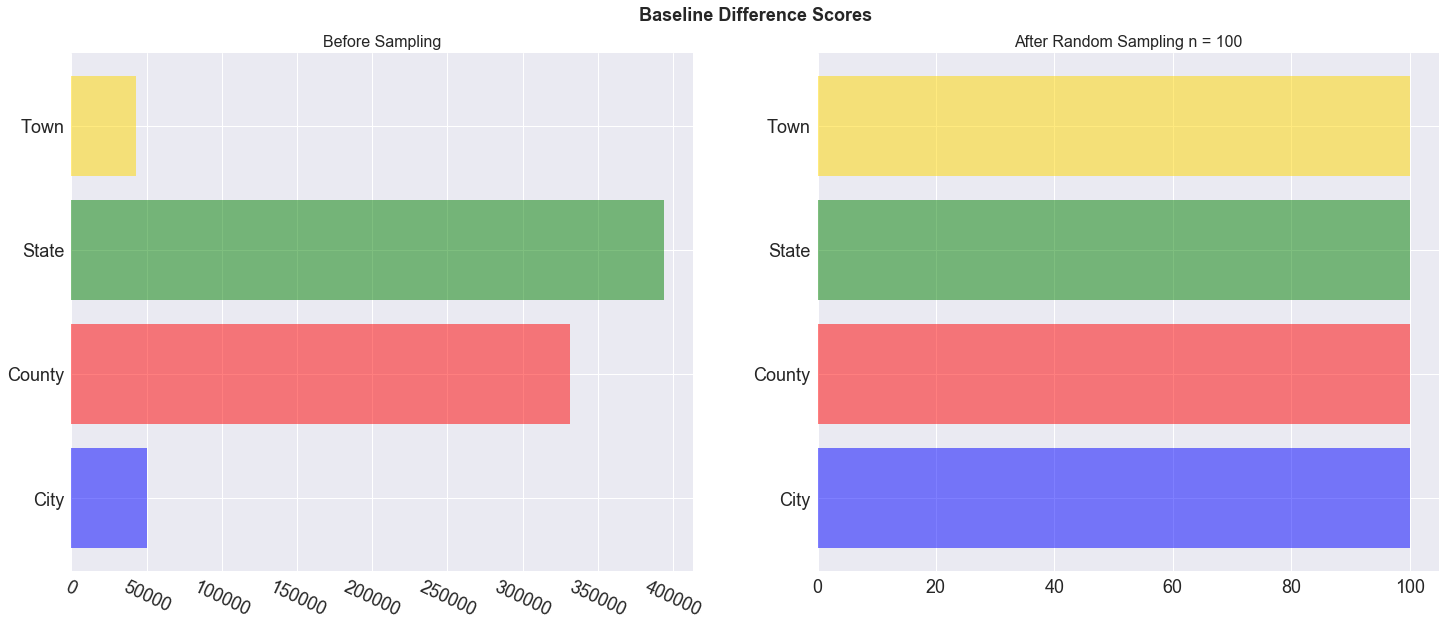

In [23]:
# Length of the dataframe of regions
len_state = len(state_df)
len_county = len(county_df)
len_town = len(town_df)
len_city = len(city_df)

# Random Sample of 100
ns = 100

samp_state_df = state_df.sample(n=ns)
samp_county_df = county_df.sample(n=ns)
samp_town_df = town_df.sample(n=ns)
samp_city_df = city_df.sample(n=ns)

# Baseline Difference Scores of the Regions.
state_base = samp_state_df['Baseline Difference Score'].tolist()
county_base = samp_county_df['Baseline Difference Score'].tolist() 
town_base = samp_town_df['Baseline Difference Score'].tolist()
city_base = samp_city_df['Baseline Difference Score'].tolist()


# Plotting 
plt.figure(figsize=(20,8))
plt.subplots_adjust(bottom=0, left=0.025, top = 0.9, right=0.975)
plt.suptitle("Baseline Difference Scores", fontsize = 18, fontweight = 'bold')
sns.set(font_scale=2)

#Subplot 1
plt.subplot(1,2,1)
plt.subplot(1,2,1).set_title("Before Sampling", fontsize = 16)
labels = ["State", "County", "Town", "City"]
no_of_records = [len_state, len_county, len_town, len_city]
plt.barh(labels, no_of_records, align = 'center', alpha = 0.5, color = ['Green','Red','Gold','Blue'])
plt.xticks(size = 18, rotation = -25)
plt.yticks(size =18)

# Subplot 2
plt.subplot(1,2,2)
plt.subplot(1,2,2).set_title("After Random Sampling n = 100", fontsize = 16)
no_of_records = [len(samp_state_df), len(samp_county_df), len(samp_town_df), len(samp_city_df)]

plt.barh(labels, no_of_records, align = 'center', alpha = 0.5, color = ['Green','Red','Gold','Blue'])
plt.xticks(size = 18)
plt.yticks(size =18)
plt.show()

#### Baseline Difference Score Distribution of Owners / Maintainers

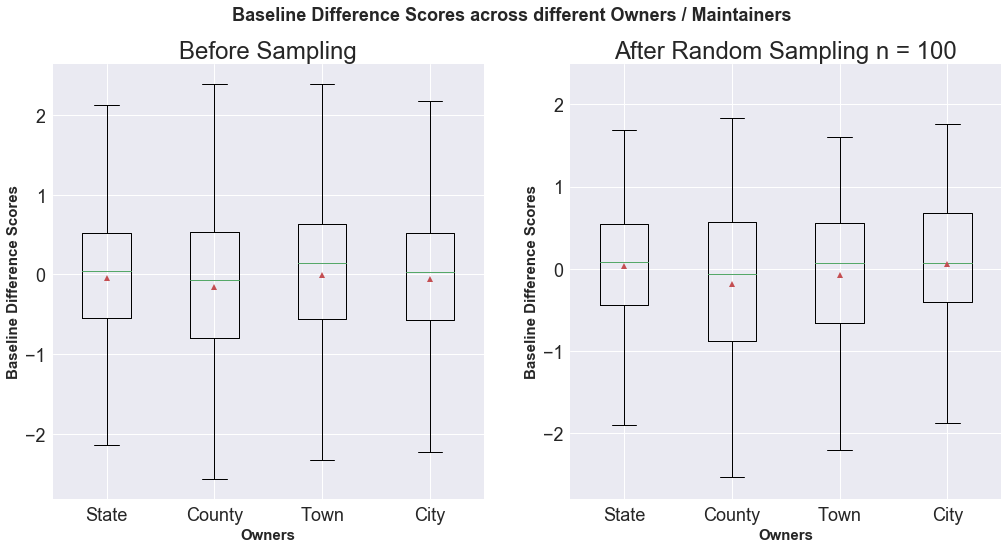

In [25]:
plt.figure(figsize=(17,8))

data = [state_df['Baseline Difference Score'].tolist(), county_df['Baseline Difference Score'].tolist(), town_df['Baseline Difference Score'].tolist(), city_df['Baseline Difference Score'].tolist()]
labels = ["State","County","Town","City"]
plt.suptitle("Baseline Difference Scores across different Owners / Maintainers", fontsize = 18, fontweight = 'bold') 
plt.title('Outliers are ignored')

# Subplot 1
plt.subplot(1,2,1)
plt.subplot(1,2,1).set_title("Before Sampling")
plt.boxplot(data, labels = labels, showfliers=True, showmeans=True)
plt.ylabel('Baseline Difference Scores', fontweight = 'bold', size = 15)
plt.xlabel("Owners", fontweight = 'bold', size = 15)
plt.xticks(size = 18)
plt.yticks(size = 18)


# Subplot 2
plt.subplot(1,2,2)
plt.subplot(1,2,2).set_title("After Random Sampling n = 100")
data_sample = [state_base, county_base, town_base, city_base]

plt.boxplot(data_sample, labels = labels, showfliers=True, showmeans=True)

plt.ylabel('Baseline Difference Scores', fontweight = 'bold', size = 15)
plt.xlabel("Owners", fontweight = 'bold', size = 15)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.show()

### ANOVA

#### One-way anova

In [26]:
stat, p_value = stats.f_oneway(state_base, 
                               county_base,
                               town_base, 
                               city_base) 
## Results
anova_result(stat, p_value)

Stat:1.5748579458206358
The p_value: 0.194920980037813
Therefore we accept the Null Hypothesis - The average of the dependent variable is same for all groups


### Post-hoc Testing

#### Separate t-test

In [27]:
# Dataframe of each Owner as a column
o_df = pd.DataFrame({'State':state_base,'County':county_base,'Town':town_base, 'City': city_base})

# Dataframe of column of Owner and column of score
baselines =state_base+county_base+town_base+city_base
owners = ['State']*(len(state_base))+['County']*(len(county_base))+['Town']*(len(town_base))+['City']*(len(city_base))
phoc_owners_df = pd.DataFrame({'Owner':owners, 'Baseline Difference Score':baselines})

# Function: returns a x into 2 dimension of list of pairs
def getPairs(columns_list):
    pairs = []
    for col1 in range(3):
        for col2  in range(col1+1,4):
            pairs.append((columns_list[col1], columns_list[col2]))
    return pairs

columns_list = ['State','County','Town','City']
pairs = getPairs(columns_list)

# Function: performs separate t-test on pairs of groups
def ttest(df,pairs):
    Col1 = []
    Col2 = []
    Stats = []
    pvalues = []
    Results = []
    for column1, column2 in pairs:
        stat, p = stats.ttest_ind(df[column1], df[column2])
        Col1.append(column1)
        Col2.append(column2)
        Stats.append(stat)
        pvalues.append(p)
        if p < 0.05:
            result = 'True'
        else:
            result = 'False'
        Results.append(result)
        
    df = pd.DataFrame({'Group 1':Col1, 'Group 2':Col2, 'Statistic':Stats, 'p-value':pvalues, 'Reject':Results})
    return df

# Results of separate t-test of pairs of groups
results_precp_df =  ttest(o_df,pairs)

# Result
results_precp_df

,Group 1,Group 2,Reject,Statistic,p-value
0,State,County,False,1.738878,0.083610
1,State,Town,False,0.896982,0.370818
2,State,City,False,-0.217307,0.828193
3,County,Town,False,-0.806946,0.420666
4,County,City,False,-1.894554,0.059609
5,Town,City,False,-1.076560,0.282987


#### Tukey's Test

group1,group2,meandiff,lower,upper,reject
City,County,-0.2466,-0.5755,0.0822,False
City,State,-0.026,-0.3549,0.3028,False
City,Town,-0.1378,-0.4667,0.191,False
County,State,0.2206,-0.1082,0.5495,False
County,Town,0.1088,-0.2201,0.4376,False
State,Town,-0.1118,-0.4407,0.217,False


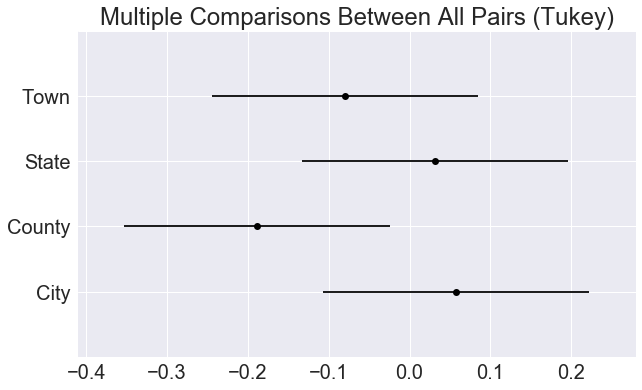

In [28]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=phoc_owners_df['Baseline Difference Score'].tolist(),# Scores
                          groups=phoc_owners_df['Owner'].tolist(),   # Owners
                          alpha=0.05)   
tukey.plot_simultaneous()    
tukey.summary()